# Training a baseline GRU model

In [24]:
import pandas as pd
import joblib
import torch, numpy as np
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    accuracy_score,
    precision_score,
    roc_auc_score,
)
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np, matplotlib.pyplot as plt

## Data loading

In [ ]:
bundle = joblib.load("baseline_data_processing/data_payload_30s.pkl")

In [ ]:
X_train = bundle["X_train"]
X_test = bundle["X_test"]
X_val = bundle["X_val"]

y_train = bundle["y_train"]
y_test = bundle["y_test"]
y_val = bundle["y_val"]

## DataLoader setup

In [ ]:
DEVICE = "cpu"
BATCH_SIZE = 256
EPOCHS = 25
LR = 1e-3  # will tune later


def make_loader(X, y, shuffle):
    tens_x = torch.tensor(X, dtype=torch.float32)
    tens_y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # (N,1) for BCE
    return DataLoader(
        TensorDataset(tens_x, tens_y),
        batch_size=BATCH_SIZE,
        shuffle=shuffle,
        drop_last=True,
    )


train_loader = make_loader(X_train, y_train, shuffle=True)
val_loader = make_loader(X_val, y_val, shuffle=False)
test_loader = make_loader(X_test, y_test, shuffle=False)

SEQ_LEN, N_FEATS = X_train.shape[1:]

## Model Definition

We create a single layer GRU that reads feature vectors, build a small head consisting of dropout plus a linear layer that maps the final hidden state to one logit (binary classification)

In [ ]:
class GRUClassifier(nn.Module):
    def __init__(self, n_feats, hidden=128, num_layers=1, dropout=0.1):
        super().__init__()
        self.gru = nn.GRU(
            input_size=n_feats,
            hidden_size=hidden,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.head = nn.Sequential(
            nn.Dropout(dropout), nn.Linear(hidden, 1)  # binary logit
        )

    def forward(self, x):
        # x : (B, T, F)
        _, h_n = self.gru(x)  # h_n : (num_layers, B, hidden)
        logits = self.head(h_n[-1])  # use last layer’s hidden
        return logits


model = GRUClassifier(n_feats=N_FEATS).to(DEVICE)
print(model)

GRUClassifier(
  (gru): GRU(10, 128, batch_first=True)
  (head): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=128, out_features=1, bias=True)
  )
)


## Training and validation loop

In [20]:
models_folder = "baseline_models/"

In [19]:
criterion = nn.BCEWithLogitsLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimiser, mode="min", factor=0.5, patience=2
)


def run_epoch(loader, train):
    total_loss, correct, total = 0.0, 0, 0
    model.train(train)
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model(xb)
        loss = criterion(logits, yb)
        if train:
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

        preds = torch.sigmoid(logits) > 0.5
        correct += (preds.float() == yb).sum().item()
        total += yb.size(0)
        total_loss += loss.item() * yb.size(0)
    return total_loss / total, correct / total

In [ ]:
best_val = 1e9
patience = 4
waited = 0
for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    va_loss, va_acc = run_epoch(val_loader, train=False)
    scheduler.step(va_loss)

    print(
        f"Epoch {epoch:02d} | "
        f"train: loss {tr_loss:.4f} acc {tr_acc:.3f} | "
        f"val: loss {va_loss:.4f} acc {va_acc:.3f}"
    )

    # early-stopping
    if va_loss < best_val:
        best_val, waited = va_loss, 0
        torch.save(model.state_dict(), models_folder + "best_gru.pt")
    else:
        waited += 1
        if waited >= patience:
            print("Early stop.")
            break

Epoch 01 | train: loss 0.4185 acc 0.808 | val: loss 0.4463 acc 0.792
Epoch 02 | train: loss 0.3629 acc 0.835 | val: loss 0.5029 acc 0.761
Epoch 03 | train: loss 0.3087 acc 0.863 | val: loss 0.5233 acc 0.778
Epoch 04 | train: loss 0.2685 acc 0.882 | val: loss 0.5903 acc 0.757
Epoch 05 | train: loss 0.2154 acc 0.908 | val: loss 0.6392 acc 0.768
Early stop.


## Test-set evaluation

In [23]:
all_pred, all_true = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        logits = model(xb.to(DEVICE))
        all_pred.extend((torch.sigmoid(logits) > 0.5).cpu().numpy().ravel())
        all_true.extend(yb.numpy().ravel())
y_pred = np.array(all_pred, dtype=int)
y_true = np.array(all_true, dtype=int)

Metrics

In [25]:
cm = confusion_matrix(y_true, y_pred)  # [[TN FP] [FN TP]]
TN, FP, FN, TP = cm.ravel()

acc = accuracy_score(y_true, y_pred)
recall = TP / (TP + FN + 1e-12)  # sensitivity / TPR
spec = TN / (TN + FP + 1e-12)  # specificity / TNR
prec = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Confusion matrix (rows: true, cols: pred)")
print(cm, "\n")
print(f"Accuracy     : {acc :.3f}")
print(f"Recall (TPR) : {recall :.3f}")
print(f"Specificity  : {spec :.3f}")
print(f"Precision    : {prec :.3f}")
print(f"F1-score     : {f1 :.3f}")

Confusion matrix (rows: true, cols: pred)
[[21740  5933]
 [ 4770  7749]] 

Accuracy     : 0.734
Recall (TPR) : 0.619
Specificity  : 0.786
Precision    : 0.566
F1-score     : 0.592


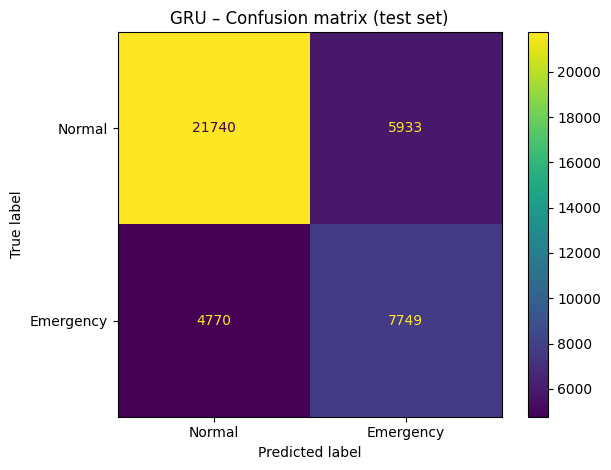

In [ ]:
fig1, ax1 = plt.subplots()
ConfusionMatrixDisplay(cm, display_labels=["Normal", "Emergency"]).plot(ax=ax1)
ax1.set_title("GRU - Confusion matrix (test set)")
plt.tight_layout()
plt.show()

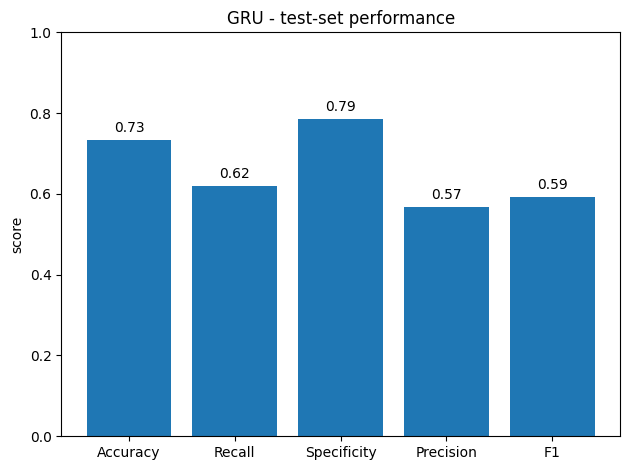

In [ ]:
fig2, ax2 = plt.subplots()
metrics = [acc, recall, spec, prec, f1]
labels = ["Accuracy", "Recall", "Specificity", "Precision", "F1"]
ax2.bar(labels, metrics)
ax2.set_ylim(0, 1)
ax2.set_ylabel("score")
ax2.set_title("GRU - test-set performance")
for idx, v in enumerate(metrics):  # annotate bars
    ax2.text(idx, v + 0.02, f"{v:.2f}", ha="center")
plt.tight_layout()
plt.show()